# Load modules

In [1]:
# Import general pkgs
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (confusion_matrix, auc, classification_report, dcg_score, f1_score, precision_recall_curve,\
                             precision_score, recall_score, roc_auc_score, roc_curve)
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb

import pycaret
import pandas_profiling
import matplotlib.pyplot as plt
import itertools

import pickle
import joblib
import math
import os

from pygam import LogisticGAM, s, f
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import custom pkgs
import sys
sys.path.append("../../../utils/")
import utils

sys.path.append("../santander/jihyun/")
import utils_jh
import utils_evaluation_jh

In [3]:
print(os.listdir('../../../data/wine_quality/raw/'))

['wine_quality.csv']


# Load data

In [41]:
path = '../../../data/wine_quaity/raw/'
df_train = pd.read_csv(path + 'wine_quality.csv')
seed=777

In [7]:
df_train.sample(3)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
779            7.1              0.52         0.03             2.6      0.076   
472           12.5              0.37         0.55             2.6      0.083   
530            9.1              0.22         0.24             2.1      0.078   

     free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
779                 21.0                  92.0  0.99745  3.50       0.60   
472                 25.0                  68.0  0.99950  3.15       0.82   
530                  1.0                  28.0  0.99900  3.41       0.87   

     alcohol  quality  
779      9.8        5  
472     10.4        6  
530     10.3        6

# Prepare dataset for modeling

In [49]:
# 컬럼명 형식 변경 : 소문자 / 공백을 under bar (_)로 대체
col_list = df_train.columns.tolist()
col_list = [i.replace(' ', '_') for i in col_list]
col_list = [i.lower() for i in col_list]

# dataframe에 컬럼명 변경 반영
df_train = df_train.set_axis(col_list, axis=1)

In [51]:
joblib.dump(df_train,'wine_qulailty_rename_col.csv')

['wine_qulailty_rename_col.csv']

In [53]:
# X, y for modeling
X = df_train.drop(['quality'], axis=1)
y = df_train['quality']

In [66]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
print('train : ', X_train.shape, '\t', 'test : ', X_valid.shape)

train :  (1279, 11) 	 test :  (320, 11)


# Baseline - EBM

In [71]:
# pycaret
from pycaret.regression import *
exp_reg = setup(df_train, target = 'quality')

best_model = compare_models(include=['lightgbm','rf'],
               fold = 3,  round = 2,  sort = 'RMSE', verbose = True)
best_model

# best_model = compare_models(include=['lightgbm','rf','xgboost','catboost'],
#                fold = 3,  round = 2,  sort = 'RMSE', verbose = True)
# -----> xgboost,catboost estimator name 오류 지속발생으로 작동안됨

## Preprocessing using pycaret
# from pycaret.regression import *
# reg1 = setup(df, target = 'quality', 
#              session_id=123, 
#              train_size=0.8,
#              fold=2,
#              log_experiment=True, 
#              feature_interaction=True,
#              feature_ratio=True,
#              #polynomial_features=True,
#              trigonometry_features=True,
#              group_features=['fixed acidity','volatile acidity','citric acid','free sulfur dioxide','total sulfur dioxide'],
#              bin_numeric_features=['citric acid'],
#              experiment_name='wine2')
# get_config('X').dtypes

IntProgress(value=0, description='Processing: ', max=14)

\
                                                 
Initiated  . . . . . . . . . . . . . . . . . .   
Status     . . . . . . . . . . . . . . . . . .   
Estimator  . . . . . . . . . . . . . . . . . .   

                                            
                                            
Initiated                         10:52:11  
Status              Compiling Final Models  
Estimator  Light Gradient Boosting Machine

ValueError: Series.dtypes must be int, float or bool

## Training

In [65]:
# interpretml EBM
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret.data import Marginal
from interpret.perf import RegressionPerf
from interpret import show

In [69]:
ebm = ExplainableBoostingRegressor(interactions=0, random_state=seed) # no interaction terms
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(binning='quantile', early_stopping_rounds=50,
                             early_stopping_tolerance=0.0001,
                             feature_names=['fixed_acidity', 'volatile_acidity',
                                            'citric_acid', 'residual_sugar',
                                            'chlorides', 'free_sulfur_dioxide',
                                            'total_sulfur_dioxide', 'density',
                                            'ph', 'sulphates', 'alcohol'],
                             feature_types=['continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous'],
                             inner_bags=0, interacti

## EBM result

In [70]:
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_train, y_train, name = 'EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7001/140547940037008/ -->

In [72]:
# ebm global
ebm_global = ebm.explain_global(name = 'EBM')
show(ebm_global)

<!-- http://127.0.0.1:7001/140547319048128/ -->

In [73]:
ebm_local = ebm.explain_local(X_train[:10], y_train[:10], name='EBM')
show(ebm_local)

<!-- http://127.0.0.1:7001/140547642354128/ -->

## Predict

In [ ]:
df_rslt_tr = utils_jh.classification_result(ebm, X_train, y_train)
df_rslt_vld = utils_jh.classification_result(ebm, X_valid, y_valid)

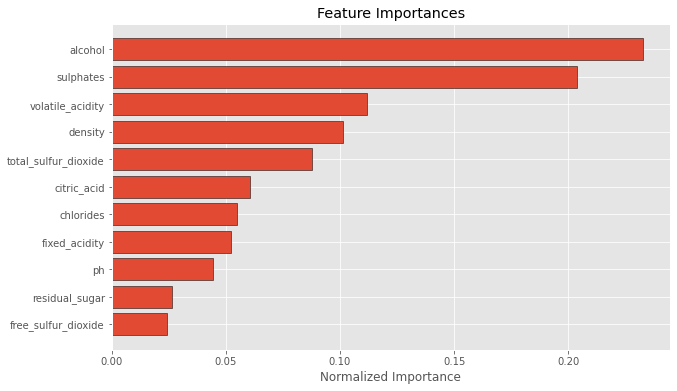

index importance               feature importance_normalized
0      10   0.178075               alcohol              0.232865
1       9   0.155964             sulphates              0.203952
2       1   0.085563      volatile_acidity               0.11189
3       7   0.077438               density              0.101265
4       6    0.06717  total_sulfur_dioxide              0.087838
5       2   0.046157           citric_acid              0.060358
6       4   0.042097             chlorides               0.05505
7       0   0.039855         fixed_acidity              0.052117
8       8   0.033747                    ph               0.04413
9       3   0.020007        residual_sugar              0.026163
10      5   0.018638   free_sulfur_dioxide              0.024373

In [75]:
ebm.feature_names

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'ph',
 'sulphates',
 'alcohol']

In [84]:
ebm.score(X_train, y_train)

0.4998571600444853

In [79]:
ebm.predict(X_valid)

array([5.63078338, 5.26446799, 6.02307881, 5.64836284, 5.59080661,
       5.77808623, 6.37220941, 5.50224574, 5.64789827, 5.90666031,
       5.6419503 , 5.07171926, 5.8394834 , 5.49646791, 5.56408073,
       6.39295003, 5.88630587, 6.22197186, 6.71266459, 5.17553907,
       5.1245742 , 5.79102021, 6.28185579, 5.0752053 , 5.29462302,
       5.65961309, 5.98530147, 5.4409932 , 5.70605477, 5.12950529,
       5.35083095, 5.58177429, 4.77021821, 5.43621128, 5.67707468,
       6.43639624, 5.93264551, 6.03357709, 5.73114122, 5.64675631,
       5.53714901, 5.89339666, 5.69794181, 4.84297424, 5.34595115,
       5.67230147, 5.7914665 , 6.38044173, 5.03128576, 5.10634438,
       5.12797319, 5.71444723, 4.91234811, 5.16751932, 4.99720913,
       5.24478347, 5.33286376, 5.97234189, 6.21892631, 5.52431871,
       6.07962931, 4.89053167, 6.24694545, 5.78336714, 5.28317781,
       5.08021143, 5.16763361, 5.67230147, 5.92017538, 5.31248379,
       6.18250901, 5.73270669, 5.8044794 , 5.51849065, 5.53796

# Counterfactuals with DiCE

In [85]:
df_train

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  
0         9.4        5  
1         9.8        5  
2         9.8        5  
3         9.8        6  
4         9.4        5  
...       ...      ...  
1594     10.5        5  
1595     11.2        6  
1596     11.0        6  
1597     10.2        5  
1598     11.0        6  

[1599 rows x 12 columns]

In [89]:
import dice_ml
from dice_ml import Dice

# Dataset for training an ML model
d = dice_ml.Data(dataframe=df_train,
                 continuous_features= X_train.columns.tolist(), 
                 outcome_name='quality')

# Pre-trained ML model
m = dice_ml.Model(model=ebm, backend='sklearn', model_type='regressor')

# DiCE explanation instance
exp_random = dice_ml.Dice(d,m)

In [90]:
exp_genetic = Dice(d, m, method='genetic')

In [91]:
X_train

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
108             8.0             0.330         0.53             2.5      0.091   
1336            6.0             0.500         0.00             1.4      0.057   
1583            6.2             0.460         0.29             2.1      0.074   
277            11.5             0.180         0.51             4.0      0.104   
1573            6.0             0.580         0.20             2.4      0.075   
...             ...               ...          ...             ...        ...   
1193            6.4             0.885         0.00             2.3      0.166   
228             7.7             0.430         0.25             2.6      0.073   
932             7.6             0.400         0.29             1.9      0.078   
1114            5.0             0.400         0.50             4.3      0.046   
188             7.9             0.500         0.33             2.0      0.084   

      free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
108                  18.0                  80.0  0.99760  3.37       0.80   
1336                 15.0                  26.0  0.99448  3.36       0.45   
1583                 32.0                  98.0  0.99578  3.33       0.62   
277                   4.0                  23.0  0.99960  3.28       0.97   
1573                 15.0                  50.0  0.99467  3.58       0.67   
...                   ...                   ...      ...   ...        ...   
1193                  6.0                  12.0  0.99551  3.56       0.51   
228                  29.0                  63.0  0.99615  3.37       0.58   
932                  29.0                  66.0  0.99710  3.45       0.59   
1114                 29.0                  80.0  0.99020  3.49       0.66   
188                  15.0                 143.0  0.99680  3.20       0.55   

      alcohol  
108       9.6  
1336      9.5  
1583      9.8  
277      10.1  
1573     12.5  
...       ...  
1193     10.8  
228      10.5  
932       9.5  
1114     13.6  
188       9.5  

[1279 rows x 11 columns]

In [92]:
X_train[2:3]

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
1583            6.2              0.46         0.29             2.1      0.074   

      free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
1583                 32.0                  98.0  0.99578  3.33       0.62   

      alcohol  
1583      9.8

In [100]:
# Single input
query_instances = X_train[2:3]
genetic_wine = exp_genetic.generate_counterfactuals(query_instances,
                                                    total_CFs=10, 
                                                    desired_range=[7,9])
#                                                     random_seed=seed) #hyperparam없음
genetic_wine.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:22<00:00, 22.82s/it]

Query instance (original outcome : 5)


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            6.2              0.46         0.29             2.1      0.074   

   free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                 32.0                  98.0  0.99578  3.33       0.62   

   alcohol   quality  
0      9.8  5.213243


Diverse Counterfactual set (new outcome: [7, 9])


fixed_acidity volatile_acidity citric_acid residual_sugar chlorides  \
0           9.1              0.3         0.3            2.0      0.06   
1           7.9              0.5         0.3            2.5      0.08   
2           9.3              0.3         0.5            8.1      0.04   
3           7.7              0.2         0.3           10.5      0.05   
4          12.8              0.2         0.7            9.0      0.24   

  free_sulfur_dioxide total_sulfur_dioxide density   ph sulphates alcohol  \
0                12.0                 25.0  0.9952  3.3       0.8    11.7   
1                 8.0                 17.0  0.9923  3.2       0.7    13.1   
2                47.3                235.8  0.9923  3.3       1.2    13.3   
3                71.1                234.4   0.992  3.5       1.4    12.0   
4                62.3                183.2  0.9924  3.3       1.7    14.5   

             quality  
0  7.018952776914278  
1  7.150601868594079  
2  7.025714617751678  
3  7.006000403388241  
4  7.263423709669138

In [101]:
# Multiple input
query_instances = X_train[2:5]
genetic_wine = exp_genetic.generate_counterfactuals(query_instances,
                                                    total_CFs=10, 
                                                    desired_range=[7,9])
#                                                     random_seed=seed) #hyperparam없음
genetic_wine.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 3/3 [01:15<00:00, 25.04s/it]

Query instance (original outcome : 5)


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            6.2              0.46         0.29             2.1      0.074   

   free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                 32.0                  98.0  0.99578  3.33       0.62   

   alcohol   quality  
0      9.8  5.213243


Diverse Counterfactual set (new outcome: [7, 9])


fixed_acidity volatile_acidity citric_acid residual_sugar chlorides  \
0           9.1              0.3         0.3            2.0      0.06   
1           9.3              0.2         0.7           11.3      0.32   
2           7.9              0.5         0.3            2.5      0.08   
3           9.1              0.1         0.3            0.9      0.08   

  free_sulfur_dioxide total_sulfur_dioxide density   ph sulphates alcohol  \
0                12.0                 25.0  0.9952  3.3       0.8    11.7   
1                54.5                 41.8  0.9948  2.8       0.9    13.6   
2                 8.0                 17.0  0.9923  3.2       0.7    13.1   
3                 8.0                 36.1  0.9923  2.9       0.7    13.9   

             quality  
0  7.018952776914278  
1  7.160465802200357  
2  7.150601868594079  
3  7.382504353021474

Query instance (original outcome : 6)


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0           11.5              0.18         0.51             4.0      0.104   

   free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                  4.0                  23.0   0.9996  3.28       0.97   

   alcohol   quality  
0     10.1  5.871354


Diverse Counterfactual set (new outcome: [7, 9])


fixed_acidity volatile_acidity citric_acid residual_sugar chlorides  \
0           9.1              0.3         0.3            2.0      0.06   

  free_sulfur_dioxide total_sulfur_dioxide density   ph sulphates alcohol  \
0                12.0                 25.0  0.9952  3.3       0.8    11.7   

             quality  
0  7.018952776914278

Query instance (original outcome : 6)


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            6.0              0.58          0.2             2.4      0.075   

   free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                 15.0                  50.0  0.99467  3.58       0.67   

   alcohol   quality  
0     12.5  6.025825


Diverse Counterfactual set (new outcome: [7, 9])


fixed_acidity volatile_acidity citric_acid residual_sugar chlorides  \
0           9.1              0.3         0.3            2.0      0.06   
1           7.9              0.5         0.3            2.5      0.08   
2          14.3              0.7         0.1           11.3      0.09   
3           7.9              0.5         0.3            2.5      0.01   
4           4.6              0.1         0.3            0.9      0.01   
5           4.6              0.1         0.3            0.9      0.01   
6           4.6              0.1         0.0            2.5      0.01   
7           5.0              0.2         0.3           11.5       0.1   
8           4.6              0.1         0.0            0.9      0.01   
9           4.6              0.1         0.0            0.9      0.01   

  free_sulfur_dioxide total_sulfur_dioxide density   ph sulphates alcohol  \
0                12.0                 25.0  0.9952  3.3       0.8    11.7   
1                 8.0                 17.0  0.9923  3.2       0.7    13.1   
2                22.2                 91.7  0.9924  3.6       1.3    13.3   
3                 1.0                  6.0  0.9923  3.2       0.7    13.1   
4                 8.0                 11.7  0.9923  2.7       0.7    14.6   
5                 1.0                 11.7  0.9923  2.7       0.7    14.6   
6                 8.0                 11.7  0.9923  2.7       0.7    14.6   
7                27.8                 39.2  0.9922  3.7       0.9    14.7   
8                 8.0                 11.7  0.9923  2.7       0.7    14.6   
9                 1.0                 11.7  0.9923  2.7       0.7    14.6   

             quality  
0  7.018952776914278  
1  7.150601868594079  
2  7.052012073584648  
3  7.025671436079846  
4  7.277198550858654  
5  7.307372913835591  
6  7.047165828330671  
7  7.008959254632277  
8  7.059082193221717  
9  7.089256556198654

In [107]:
df_train.iloc[1583]

fixed_acidity            6.20000
volatile_acidity         0.46000
citric_acid              0.29000
residual_sugar           2.10000
chlorides                0.07400
free_sulfur_dioxide     32.00000
total_sulfur_dioxide    98.00000
density                  0.99578
ph                       3.33000
sulphates                0.62000
alcohol                  9.80000
quality                  5.00000
Name: 1583, dtype: float64

In [109]:
# Single input
query_instances = X_train[3:4]
genetic_wine_rnd = exp_random.generate_counterfactuals(query_instances,
                                                    total_CFs=10, 
                                                    desired_range=[7,9])
#                                                     random_seed=42) 
genetic_wine_rnd.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

Only 6 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Query instance (original outcome : 6)


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0           11.5              0.18         0.51             4.0      0.104   

   free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                  4.0                  23.0   0.9996  3.28       0.97   

   alcohol  quality  
0     10.1      6.0


Diverse Counterfactual set (new outcome: [7, 9])


fixed_acidity volatile_acidity citric_acid residual_sugar chlorides  \
0             -                -           -              -         -   
1          14.6                -           -           10.6       0.2   
2          14.6                -           -           10.6       0.2   
3          10.1                -           -              -         -   
4             -                -           -            9.2      0.03   
5          10.1                -           -              -         -   

  free_sulfur_dioxide total_sulfur_dioxide density   ph sulphates alcohol  \
0                55.2                    -  0.9923    -         -    13.8   
1                   -                    -  0.9917  3.5         -    14.0   
2                70.5                    -  0.9917  3.5         -    14.0   
3                23.5                 68.5  0.9924  2.7         -    14.7   
4                   -                    -   0.995    -       0.9    15.0   
5                23.5                 68.5  0.9924  2.7       0.7    14.7   

             quality  
0  7.035101890563965  
1  7.037757873535156  
2  7.116499900817871  
3  7.017012596130371  
4  7.045004367828369  
5  7.017467975616455